# Chat

Recall the overall workflow for retrieval augmented generation (RAG):

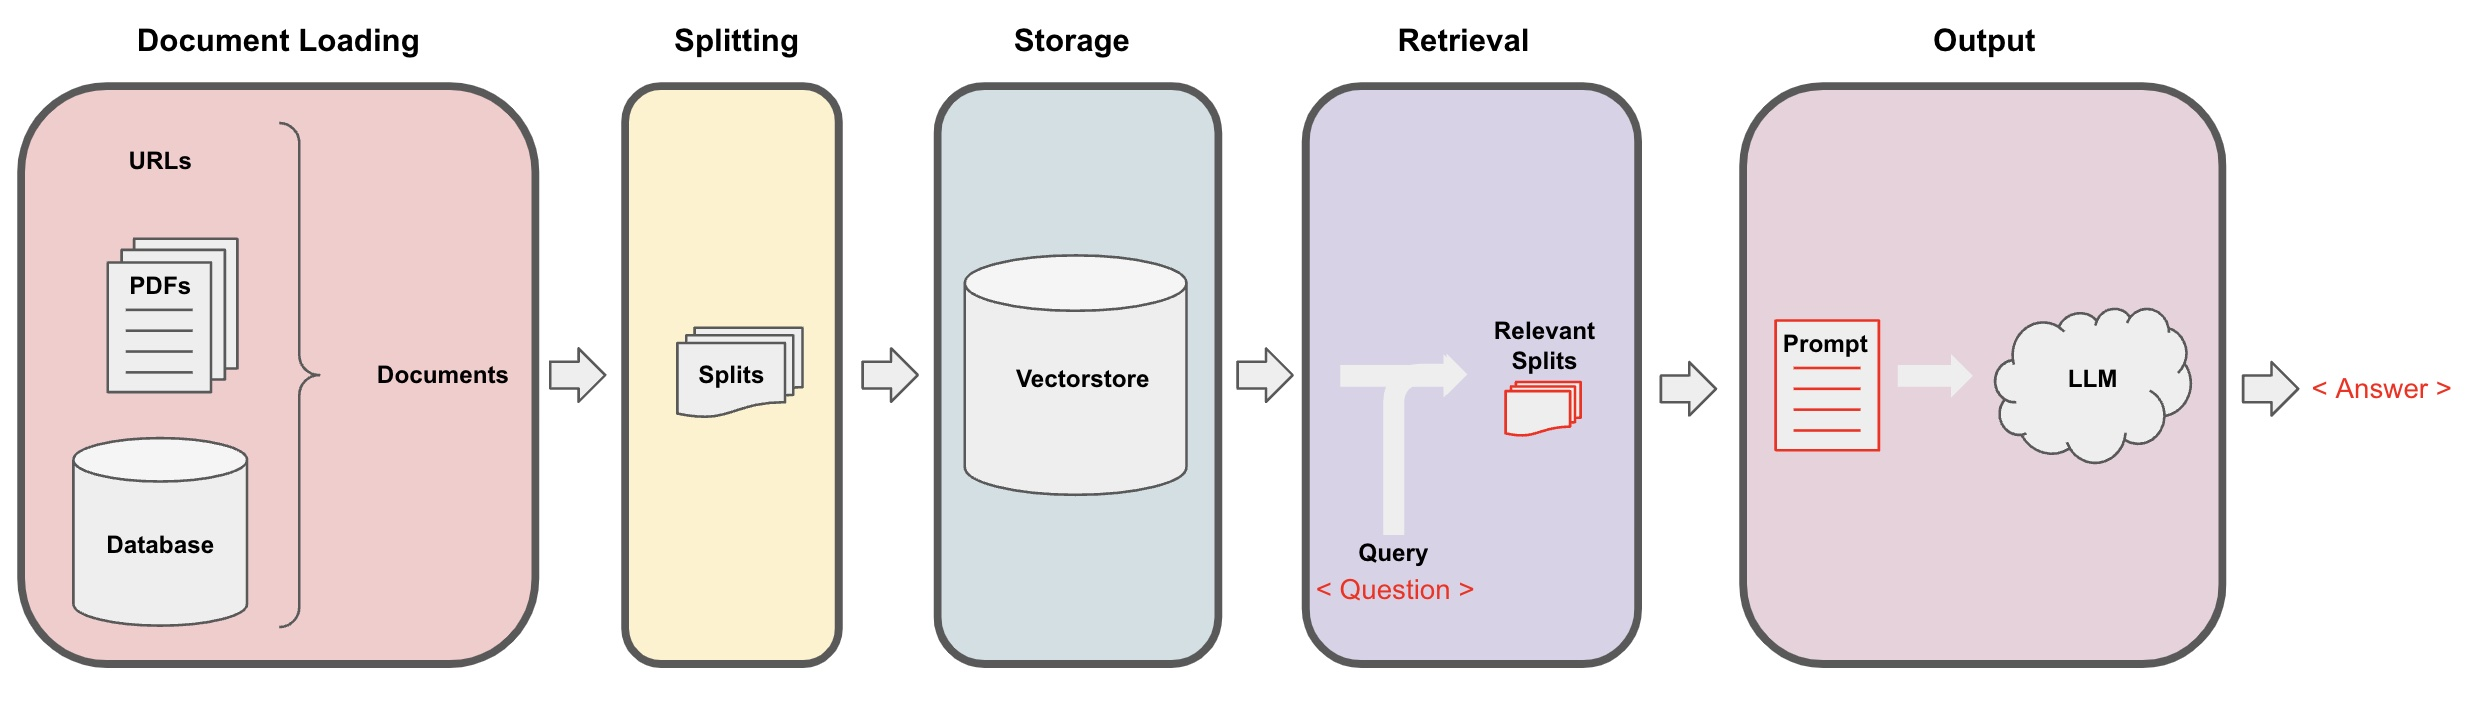

We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

We then showed how `Retrieval` can be used for output generation in Q+A using `RetrievalQA` chain.

We started with loading documents, then we split them, then we created a vector store, we talked about different types of retrieval, we've shown that we can answer questions, but we just can't handle follow-up questions, we can't have a real conversation with it. 

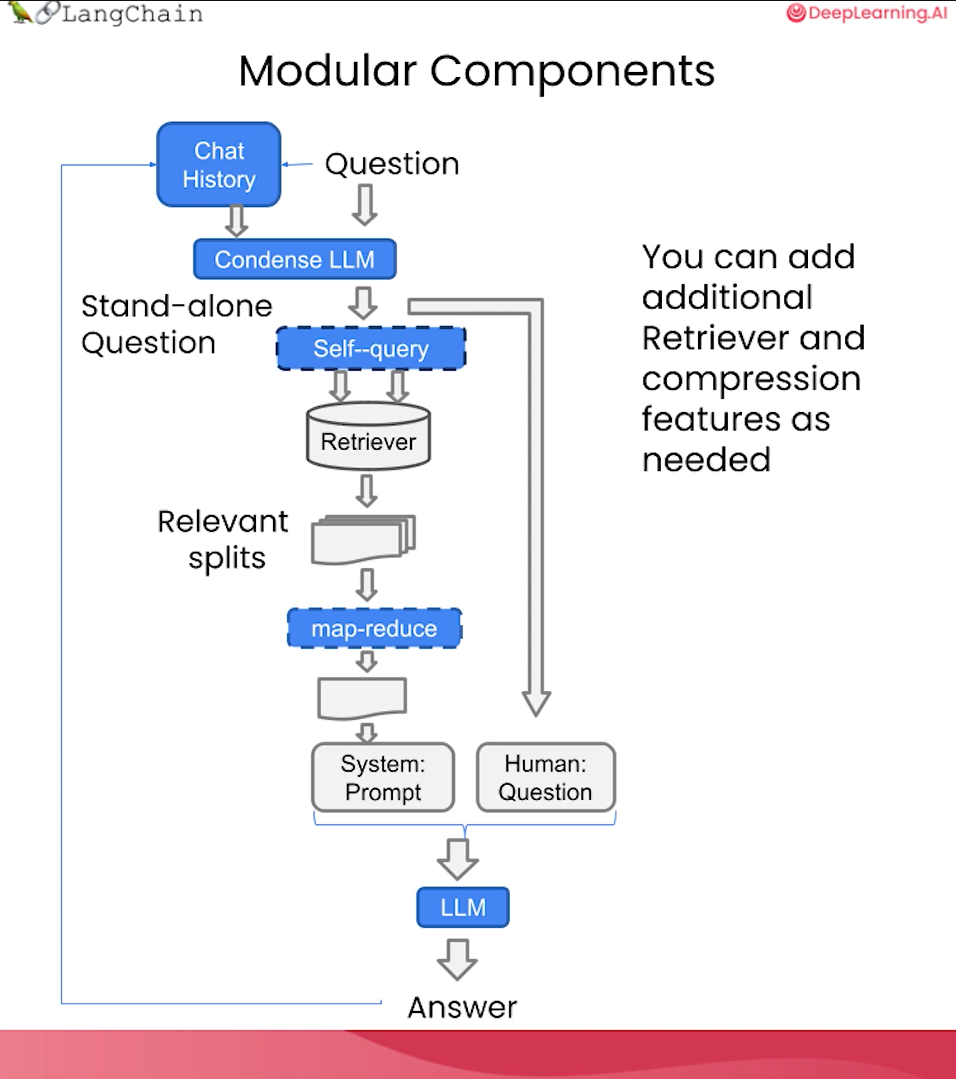

We're now going to finish up by creating a QUESTION ANSWERING CHATBOT. 

What this is going to do is, it's going to look very similar to before, but we're going to add in __this concept of chat history__. And this is any previous conversations or messages that you've exchanged with the chain. 

What that's going to allow it to do, is it's going to allow it to take that chat history into context when it's trying to answer the question. So if you're asking a follow-up question, it'll know what you're talking about.

An important thing to note here is that all the cool types of retrieval that we talked about up to this point, like self-query or compression or anything like that, you can absolutely use them here. All the components we talked about are very modular and can fit together nicely. We're just adding in this concept of chat history. 


In [ ]:
import os
import openai
import sys
sys.path.append('../..')

import panel as pn  # GUI
pn.extension()

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

The code below was added to assign the openai LLM version filmed until it is deprecated, currently in Sept 2023. 
LLM responses can often vary, but the responses may be significantly different when using a different model version.

In [ ]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

If you wish to experiment on `LangChain plus platform`:

 * Go to [langchain plus platform](https://www.langchain.plus/) and sign up
 * Create an api key from your account's settings
 * Use this api key in the code below 

In [ ]:
#import os
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
#os.environ["LANGCHAIN_API_KEY"] = "..."

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [ ]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

In [ ]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0)
llm.predict("Hello world!")

In [ ]:
# Build prompt
from langchain.prompts import PromptTemplate
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# Run chain
from langchain.chains import RetrievalQA
question = "Is probability a class topic?"
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectordb.as_retriever(),
                                       return_source_documents=True,
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})


result = qa_chain({"query": question})
result["result"]

*OUTPUT*

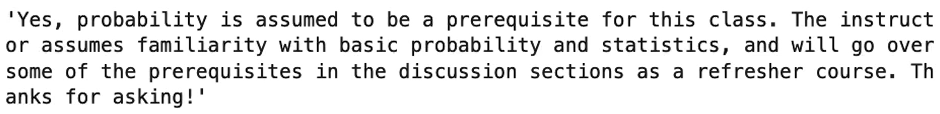

### Memory

In [ ]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

So we're going to be working with conversation buffer memory. And what this does is it's just going to simply keep a list, a buffer of chat messages in history, and it's going to pass those along with the question to the chatbot every time.

We're going to specify memory key, chat history. This is just going to line it up with an input variable on the prompt. And then we're going to specify return messages equal true. This is going to return the chat history as a list of messages as opposed to a single string. This is the simplest type of memory. 

### ConversationalRetrievalChain

LET'S NOW CREATE A NEW TYPE OF CHAIN, THE CONVERSATIONAL RETRIEVAL CHAIN. 

We pass in the language model, we pass in the retriever, and we pass in memory. 

The conversational retrieval chain adds a new bit on top of the retrieval QA chain, not just memory.

Specifically, what it adds is __it adds a step that takes the history and the new question and condenses it into a stand-alone question to pass to the vector store to look up relevant documents__. We'll take a look at this in the UI after we run it and see what effect it has. 


In [ ]:
from langchain.chains import ConversationalRetrievalChain
retriever=vectordb.as_retriever()
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [ ]:
question = "Is probability a class topic?"
result = qa({"question": question})

In [ ]:
result['answer']

*OUTPUT*

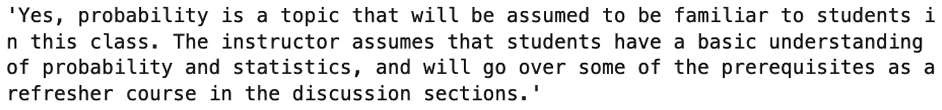

In [ ]:
question = "why are those prerequesites needed?"
result = qa({"question": question})

In [ ]:
result['answer']

*OUTPUT*

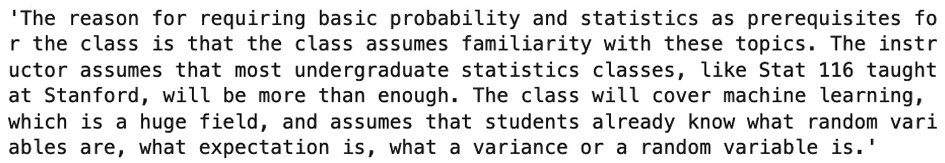

We get back an answer, and now we can see that the answer is referring to basic probability and statistics as prerequisites and expanding upon that, not getting confused with computer science as it had before. 

# UI

So here, we can already see that there's a bit more complexity. We can see that the input to the chain now has not only the `question`, but also `chat_history`. 
Chat history is coming from the memory, and this gets applied before the chain is invoked and logged in this logging system. If we look at the trace, we can see that there's two separate things going on. There's first a call to an `LLMChain`, and then there's a call to the `StuffDocumentsChain`. 


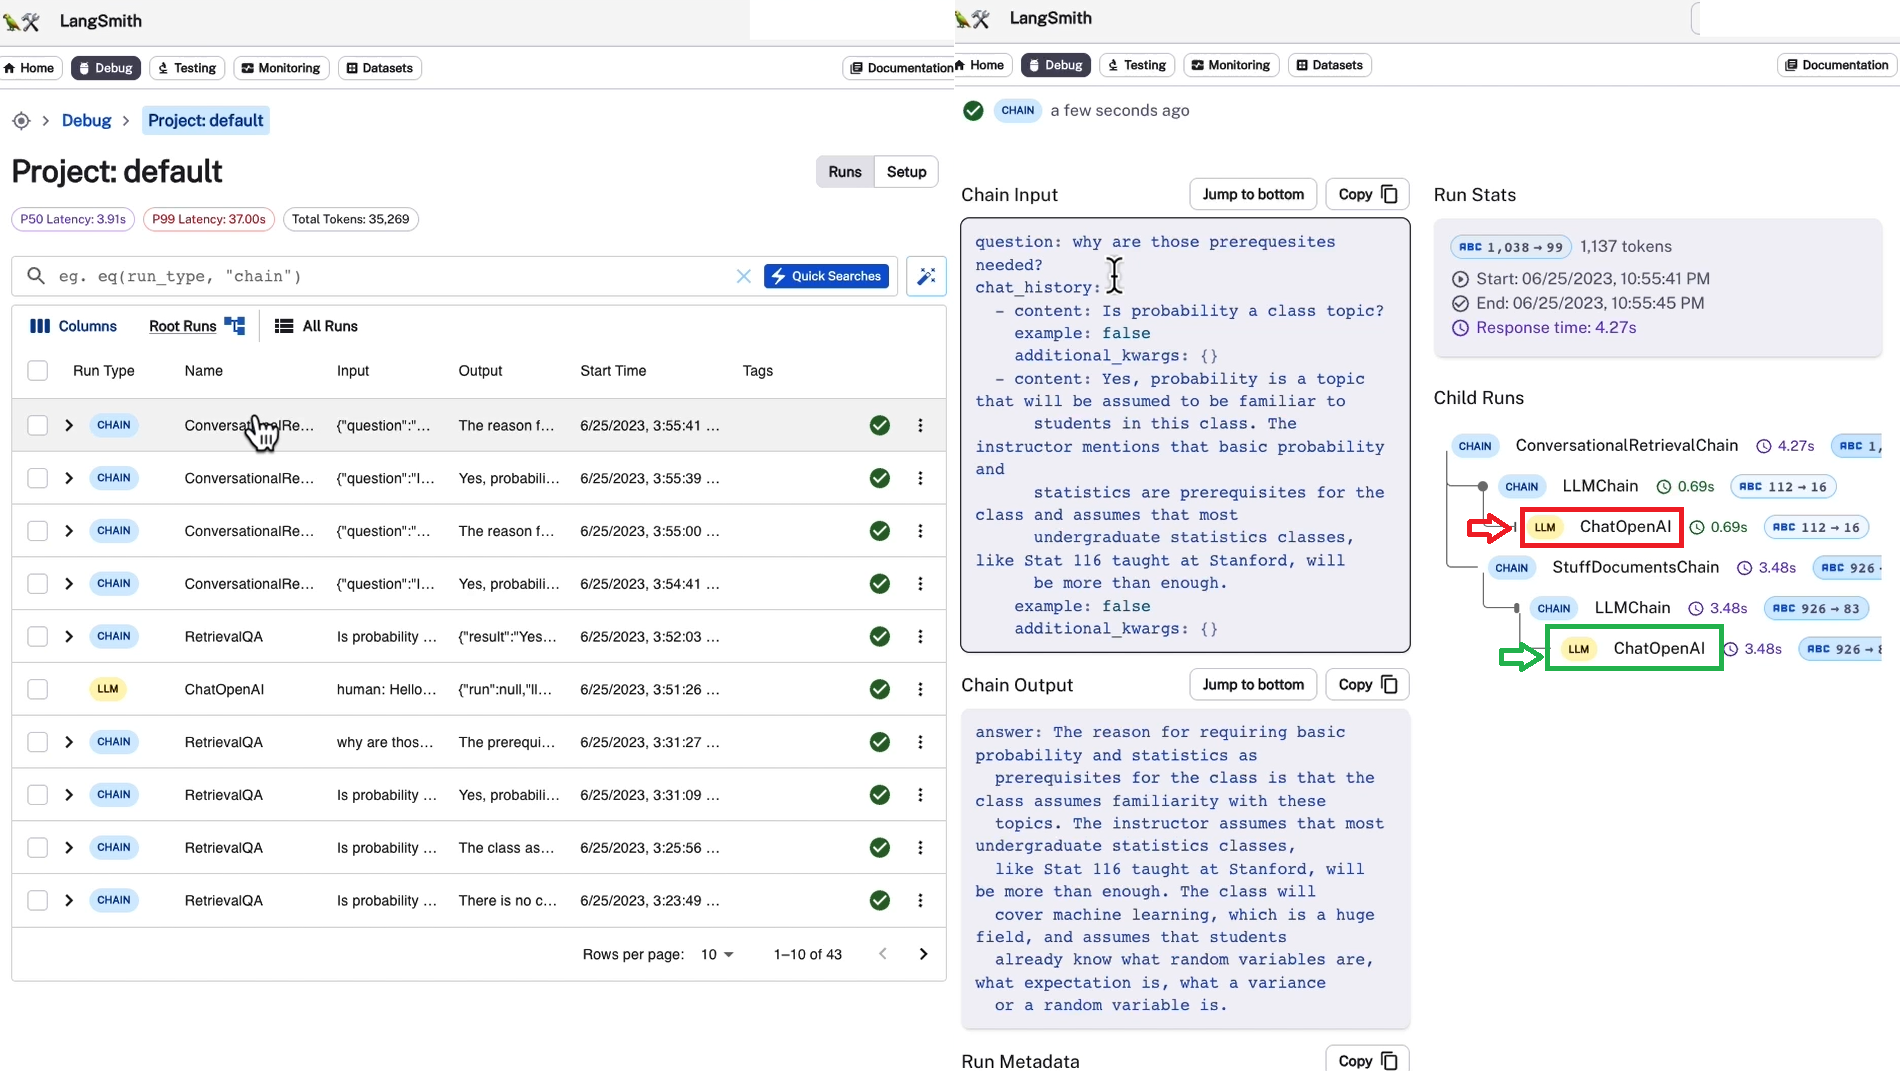

1. FIRST CALL

`Chat Model Inputs`
We can see here a prompt with some instructions. Given the following conversation, a follow-up question, rephrase the follow-up question to be a stand-alone question. Here, we have the history from before. So we have the question we asked first, is probability a class topic? We then have the assistance answers.

`Chat Model Outputs`
And then out here, we have the stand-alone question. What is the reason for requiring basic probability and statistics as prerequisites for the class? 

What happens is that stand-alone answer is then passed into the retriever, and we retrieve four documents or three documents or however many we specify. We then pass those documents to the stuff documents chain and try to answer the original question. 


2. SECOND CALL

`Chat Model Inputs`
So if we look into that, we can see that we have the system answer, use the following pieces of context to answer the user's question. We've got a bunch of context. And then we have the stand-alone question down below. 

`Chat Model Outputs`
And then we get an answer. And here's the answer that is relevant for the question at hand, which is about probability and statistics as prerequisites.  



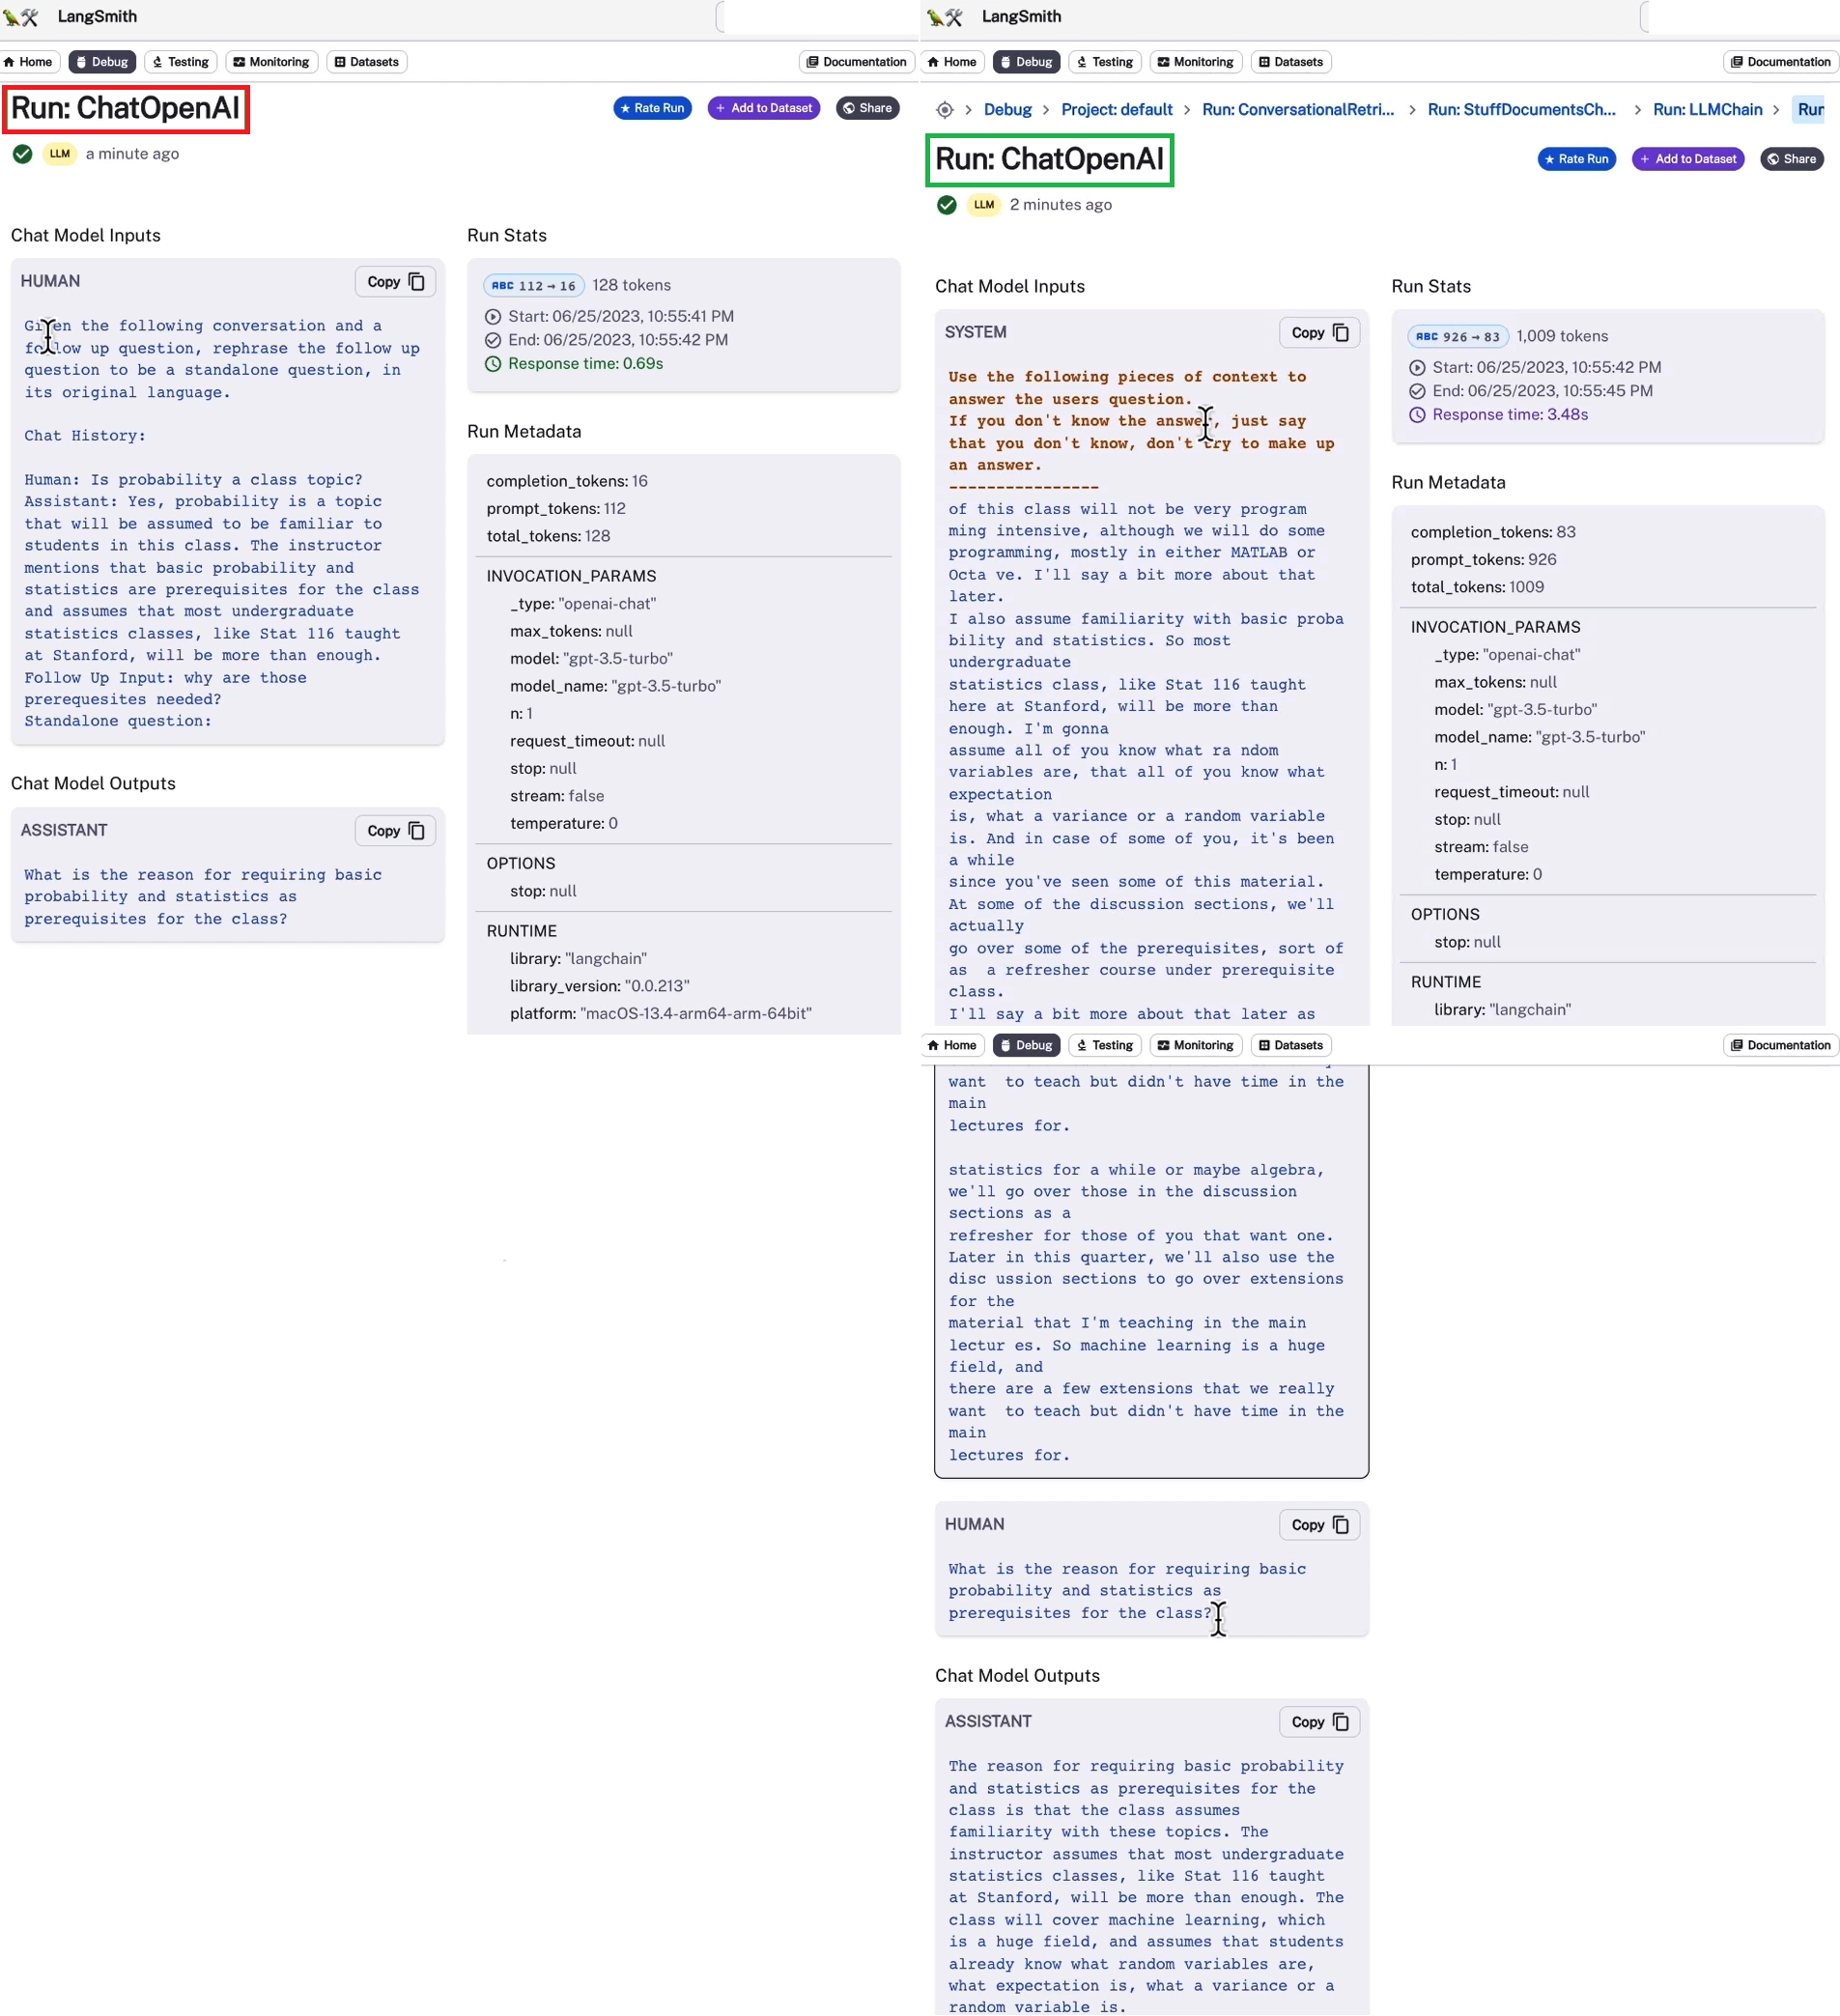

# Create a chatbot that works on your documents

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader

The chatbot code has been updated a bit since filming. The GUI appearance also varies depending on the platform it is running on.

- So we're going to load a database and retriever chain. 
- We're going to pass in a file. We're going to load it with the PDF loader. 
- We're then going to load it into documents. 
- We're going to split those documents. 
- We're going to create some embeddings and put it in a vector store.  
- We're then going to turn that vector store into a retriever. 
- We're going to use similarity here with some "search_kwargs=k", which we're going to set equal to a parameter that we can pass in. 
- And then we're going to create the conversational retrieval chain. 


In [ ]:
def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # define embedding
    embeddings = OpenAIEmbeddings()
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)
    # define retriever
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0), 
        chain_type=chain_type, 
        retriever=retriever, 
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa 


__One important thing to note here is that we're not passing in memory. We're going to manage memory externally for the convenience of the GUI below. That means that chat history will have to be managed outside the chain.__

In [ ]:
import panel as pn
import param

class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])
    
    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.loaded_file = "docs/cs229_lectures/MachineLearning-Lecture01.pdf"
        self.qa = load_db(self.loaded_file,"stuff", 4)
    
    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.pdf")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("temp.pdf", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True)

    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return 
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history') 
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self,count=0):
        self.chat_history = []
        return 


We're passing in chat history into the chain. And again, that's because we don't have memory attached to it. And then here we're extending chat history with the result.

### Create a chatbot

In [ ]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.pdf')
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp) 

jpg_pane = pn.pane.Image( './img/convchain.jpg')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWithYourData_Bot')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)
dashboard

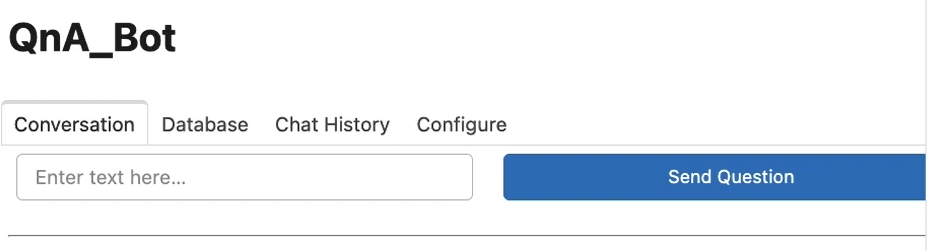

Feel free to copy this code and modify it to add your own features. You can try alternate memory and retriever models by changing the configuration in `load_db` function and the `convchain` method. [Panel](https://panel.holoviz.org/) and [Param](https://param.holoviz.org/) have many useful features and widgets you can use to extend the GUI.


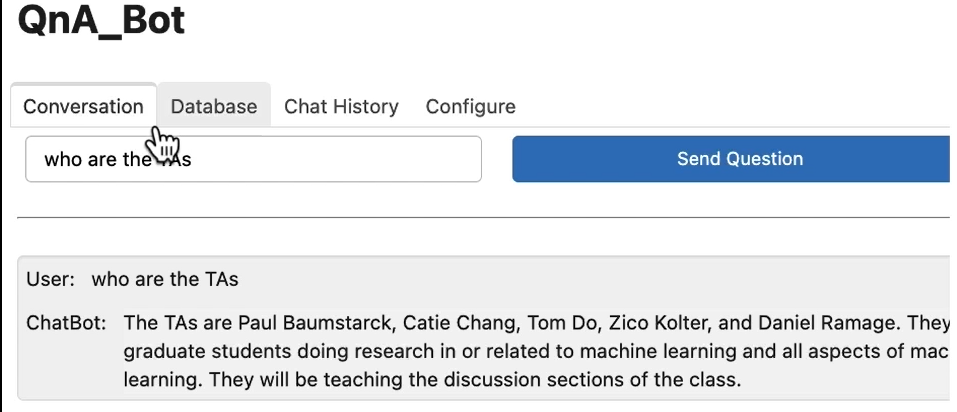

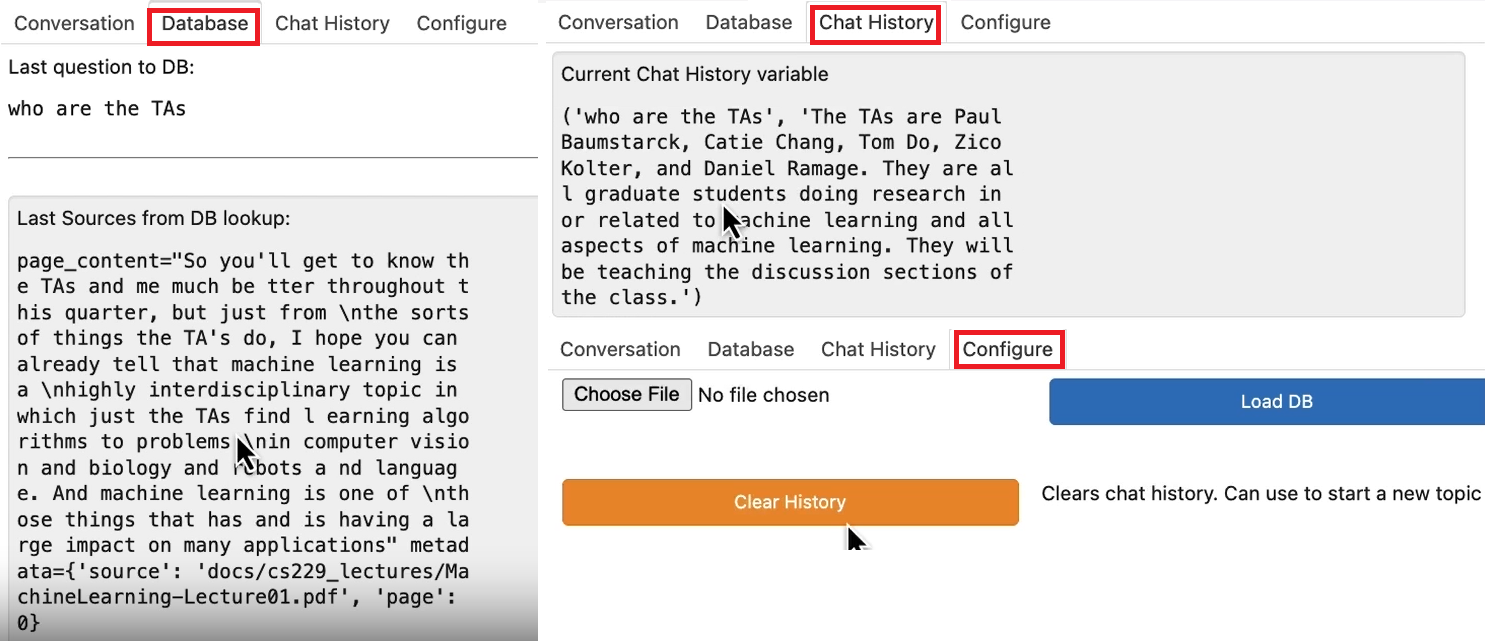

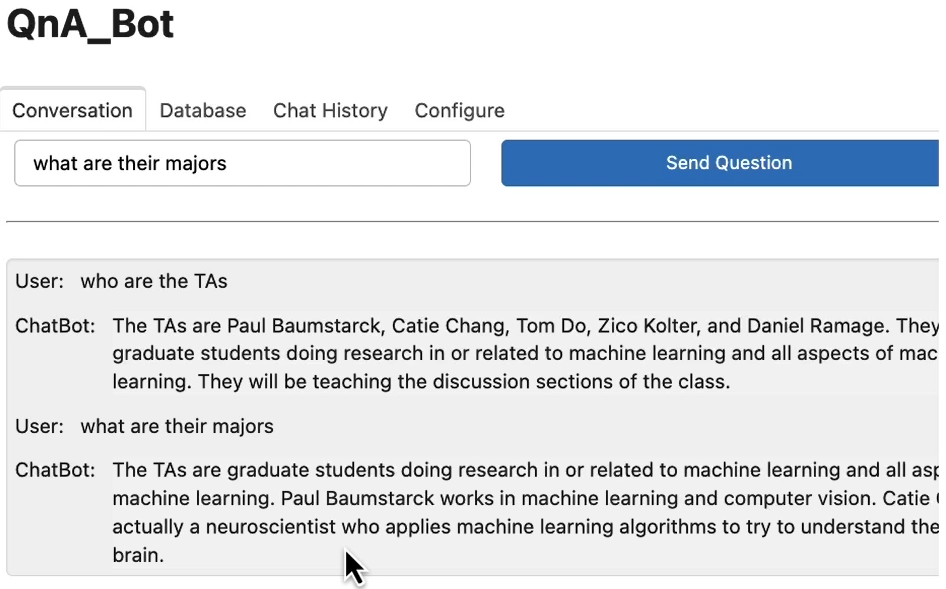

## Acknowledgments

Panel based chatbot inspired by Sophia Yang, [github](https://github.com/sophiamyang/tutorials-LangChain)

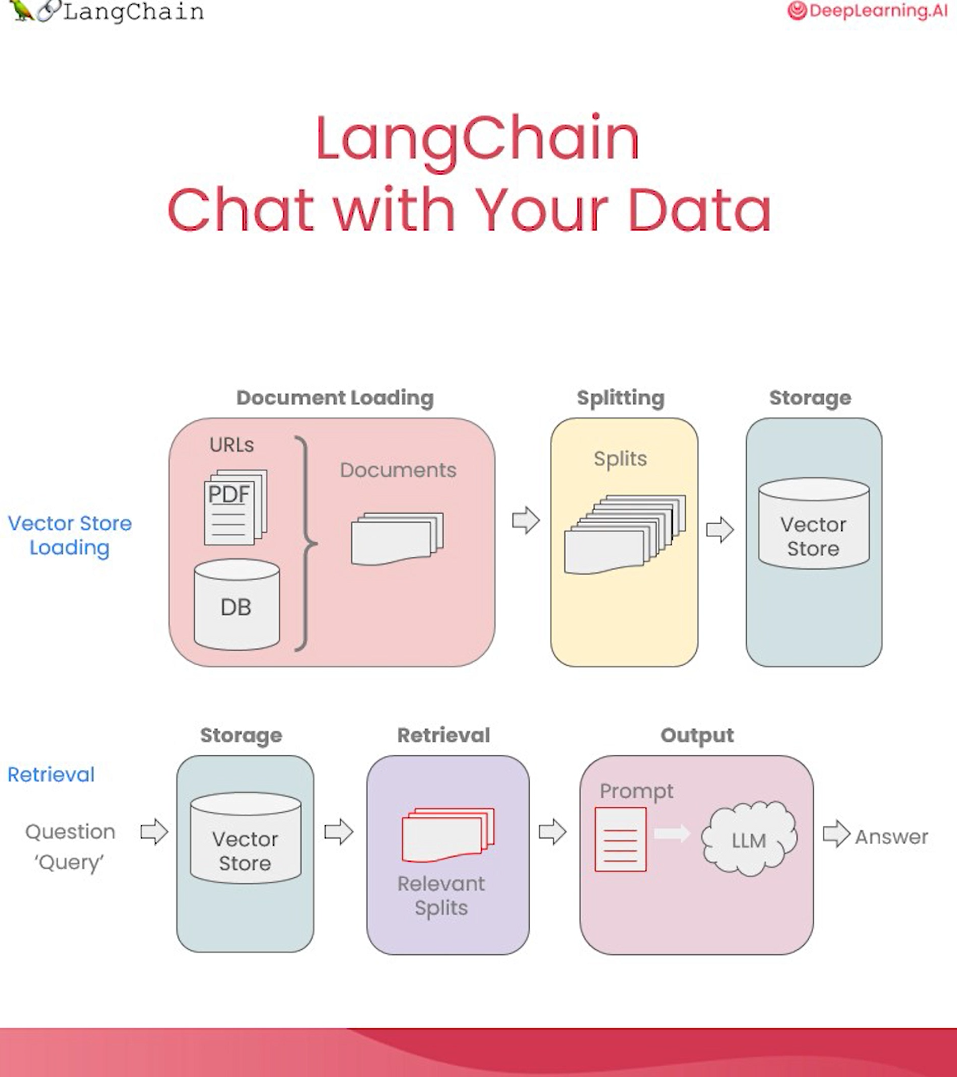